You are hired by a venture capitalist to predict the profit of a startup. Fo that you have to deal with a dataset which contains the details of 50 startup’s and predicts the profit of a new Startup based on certain features. Based on your decision and prediction, whether one should invest in a particular startup or not.

Dataset contains the following fields: 
R&D Stend - Total amount of money spent on Research and Development Administration - Total amount of money spent on Administration 
Marketing Spend - Total amount of money spent on Markeing 
State - The state where the startup operates 
Profit - Profit earned by startup

You have to perform following task before applying machine learning algorithms: 
1) Handle missing values 
2) Prepare data for training and testing
3) Apply Decision Tree algorithm to train the model
4) Apply Random Forest Regressor algorithm to train the model
5) Compare the accuracy with Linear Regression too.

In [1]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
#loading data file
data = pd.read_csv('50_Startups.csv')

In [3]:
data.head(5)

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


## Problem Definition

We're interested on determining the success of a startup given the data provided. For this, we must define a metric for "success" that can be derived from the data, so that we can train a model to predict this value effectively. Looking at the dataset, the best indicator of success is Profit, since it indicate the economic surplus of the operation. Any other variable oesn't provide a direct signal of success. So we can now define our problem as a regression one: **Given the input variables for a given startup, determine the amount of profit it will generate**

## Data Cleaning
Let's ensure that our dataset is well constructed. This means we have no empty values in our dataset. If there is any empty value, we must impute it by either removing the offending variable/row or filling the value with a meaningful one extracted from the data(mean, median, mode, etc.)

In [4]:
#displays number of columns and records/rows in dataset
#check if there is any missing data or not
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


We have 50 entries in our dataset, from which no column has null values (`50 non-null`). This means we don't need to implement any imputing, as the dataset is already in a good state. Now let's see if there are any outliers. We define an outlier if any of their values is the dataset is 3 or more standard deviations away from the mean.

In [6]:
data[(np.abs(stats.zscore(data.drop("State", axis=1))) > 3).all(axis=1)]

,R&D Spend,Administration,Marketing Spend,State,Profit


No entry in our dataset has extraordinary values in any features. We can keep going then

## Exploratory Analysis
Now we must understand the data. Here, we're trying to see how the variables behave either independently or with each other. We're also going to seek possible outliers and transform any variable that is not on a desirable format.

In [7]:
data.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


From the previous table, as well as the one in the Data Cleaning section, we can see that most of our variables are numeric and continuous. The only categorical variable we have is `State`, which is nominal. We will deal with this variable later. For now, let's have a look at the relationship between features using a pairplot and a correlation matrix

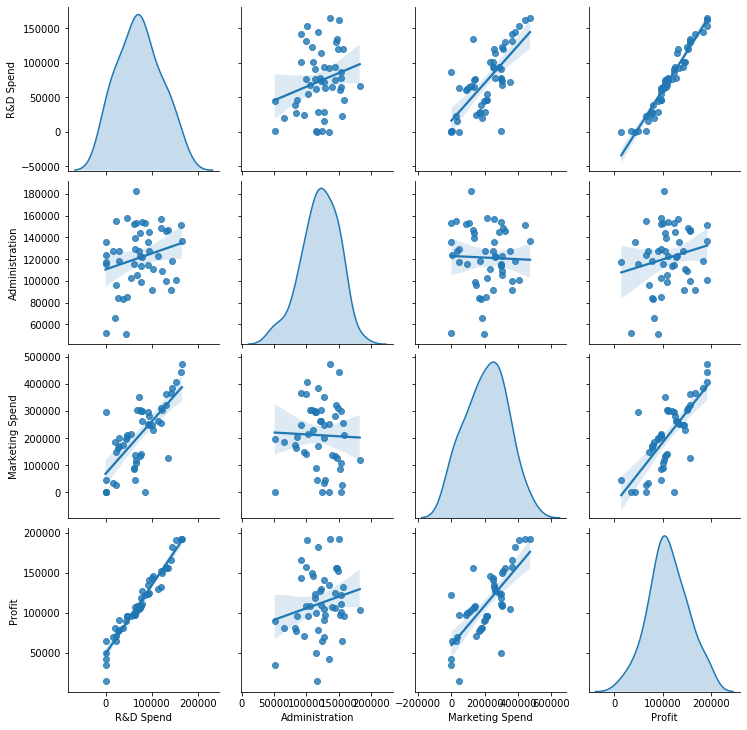

In [8]:
sns.pairplot(data, kind='reg', diag_kind='kde')

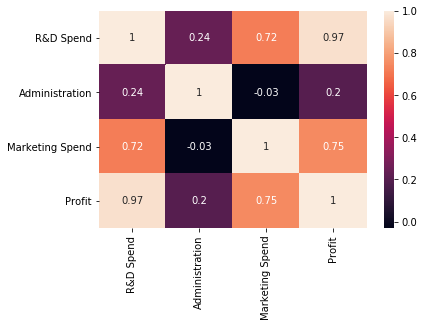

In [9]:
corr_matrix = data.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True)

We can see some pretty strong positive correlations between R&D Spend, Marketing Spend and Profit. We can also observe that all features are normally distributed, and that mostly all input features are uncorrelated. This is good for our task. Now let's have a deeper look at the `State` variable

In [10]:
data.State.describe()

count           50
unique           3
top       New York
freq            17
Name: State, dtype: object

In [11]:
data.State.unique()

array(['New York', 'California', 'Florida'], dtype=object)

We can see that the `State` variable only contains three possible values. We can therefore encode this categorical variable so it can be represented as a numerical value. This could be done with LabelEncoding or OneHotEncoding. Here, we choose the latter.

In [12]:
oh_state = pd.get_dummies(data.State, prefix='State')
data = data.join(oh_state)
data.drop('State', axis=1, inplace=True)
data.head(5)

,R&D Spend,Administration,Marketing Spend,Profit,State_California,State_Florida,State_New York
0,165349.20,136897.80,471784.10,192261.83,0,0,1
1,162597.70,151377.59,443898.53,191792.06,1,0,0
2,153441.51,101145.55,407934.54,191050.39,0,1,0
3,144372.41,118671.85,383199.62,182901.99,0,0,1
4,142107.34,91391.77,366168.42,166187.94,0,1,0


## Building the model
Now it's time to create our statistical model. Here, we have a lot of choises. Since both our input and output data is numerical, and our output data is continuous, we should use a regression model. We can therefore use Linear Regression, a Regression Tree or even a Regression Forest. Given that forests take advantage of big datasets, it doesn't seem to be a good fit for our data. But instead of only assuming things, we can do multiple tests on many of the possible models!

### Splitting the dataset
Before instantiating the model, is important to partition our data so that we can do validation tests on the models

In [14]:
#sampling the dataset
#normally 20% dataset is used for testing and 80% is used for training --> test_size=0.2 means 20%  
#Training set will be used to train the model
#Create Training and Testing sets
# Testing set will be used to test our model
from sklearn.model_selection import train_test_split
label = data.Profit
features = data.drop('Profit', axis=1)
X_train,X_test,y_train,y_test = train_test_split(features,
                                                label,
                                                test_size=0.2,
                                                random_state=1)
#converting an object to normal array
features = features.astype(float)

## Training and evaluating the models
Here, we're going to instantiate multiple models with different hyperparameters, and compare them to each other

### Linear Regression
Here we train a Linear Regression Model. Since we don't have any hyperparameter to tune in the process

In [17]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
print(reg.score(X_train,y_train))
print(reg.score(X_test,y_test))

0.9424465426893971
0.9649618042060305


With the linear regression model we obtain an R2 score of 0.96 with the test set. Not bad at all!

### Regression Trees
Here we train multiple Regression Trees

In [18]:
#Create our model using Linear Regression
from sklearn.tree import DecisionTreeRegressor
max_depth_list = [1,2,3,4,5]
min_samples_list = [1,2,3,4,5]
dtrs = []
train_scores = np.zeros((len(max_depth_list), len(min_samples_list)))
test_scores = np.zeros((len(max_depth_list), len(min_samples_list)))
for i, depth in enumerate(max_depth_list):
    dtrs_depth = []
    for j, samples in enumerate(min_samples_list):
        DTR = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=samples)
        DTR.fit(X_train,y_train)
        train_scores[i,j] = DTR.score(X_train,y_train)
        test_scores[i,j] = DTR.score(X_test,y_test)
        dtrs_depth.append(DTR)
    dtrs.append(dtrs_depth)

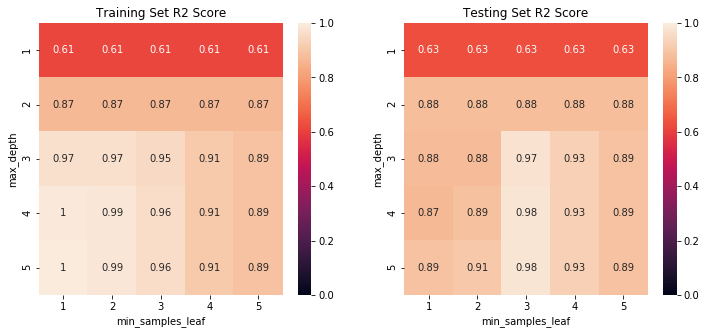

In [19]:
fig, ax =plt.subplots(1,2,figsize=(12,5))
sns.heatmap(data=train_scores.round(4),
            annot=True,
            ax=ax[0],
            vmin=0,
            vmax=1,
            xticklabels=min_samples_list,
            yticklabels=max_depth_list)
ax[0].set_title("Training Set R2 Score")
ax[0].set_xlabel("min_samples_leaf")
ax[0].set_ylabel("max_depth")

sns.heatmap(data=test_scores.round(4),
            annot=True,
            ax=ax[1],
            vmin=0,
            vmax=1,
            xticklabels=min_samples_list,
            yticklabels=max_depth_list)
ax[1].set_title("Testing Set R2 Score")
ax[1].set_xlabel("min_samples_leaf")
ax[1].set_ylabel("max_depth")
plt.show()

Here we can see the score of all the trees we created, and see how the score relates to the hyperparameters. We managed to obtain an R2 score of 0.98 with the tree that has a maximum depth of 5 and a minimum number of samples per leaf of 4. Let's keep the Decision Regression Tree with highest test score for later

In [20]:
maxdtr_i,maxdtr_j = np.unravel_index(np.argmax(test_scores), test_scores.shape)
dtr = dtrs[maxdtr_i][maxdtr_j]

### Random Regressor Forest
Here we train multiple RandomForestRegressors, with different hyperparameters

In [21]:
from sklearn.ensemble import RandomForestRegressor
RF=RandomForestRegressor(n_estimators=3)
RF.fit(X_train,y_train.ravel())
print(RF.score(X_train,y_train))
print(RF.score(X_test,y_test))

0.9314199537941092
0.9032325305611414


In [32]:
from sklearn.ensemble import RandomForestRegressor
estimators_list = [3,4,5,6,7,8,9,10]
max_depth_list = [1,2,3,4,5,6,7,8]
min_samples_list = [1,2,3,4,5,6,7,8]
rfrs = []
rfr_train_scores = np.zeros((len(estimators_list), len(max_depth_list), len(min_samples_list)))
rfr_test_scores = np.zeros((len(estimators_list), len(max_depth_list), len(min_samples_list)))

for i, est in enumerate(estimators_list):
    rfrs_est = []
    for j, depth in enumerate(max_depth_list):
        rfrs_depth = []
        for k, samples in enumerate(min_samples_list):
            RF=RandomForestRegressor(n_estimators=est, max_depth=depth, min_samples_leaf=samples)
            RF.fit(X_train,y_train)
            rfr_train_scores[i,j,k] = RF.score(X_train,y_train)
            rfr_test_scores[i,j,k] = RF.score(X_test,y_test)
            rfrs_depth.append(RF)
        rfrs_est.append(rfrs_depth)
    rfrs.append(rfrs_est)

Here we're dealing with three dimensional matrices due to the fact that we're tuning 3 hyperparameters. This is not easy to visualize and, even if we can create a 3D heatmap, it doesn't yield very intuitive information. Instead, we're going to reduce our results into 2 dimensions by taking the maximum score of one of our dimensions. In the case of random forests, I believe it is more interesting to see how the number of estimators and the maximum depth of a tree interact, since we know that a forest trains specific and somewhat overfitted trees, which often results in large trees.

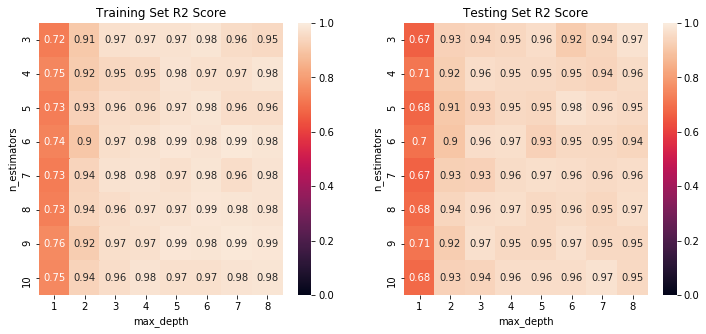

In [33]:
np.amax(rfr_test_scores, axis=2)

fig, ax =plt.subplots(1,2,figsize=(12,5))
sns.heatmap(data=np.amax(rfr_train_scores, axis=2).round(4),
            annot=True,
            ax=ax[0],
            vmin=0,
            vmax=1,
            xticklabels=max_depth_list,
            yticklabels=estimators_list)
ax[0].set_title("Training Set R2 Score")
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("n_estimators")

sns.heatmap(data=np.amax(rfr_test_scores, axis=2).round(4),
            annot=True,
            ax=ax[1],
            vmin=0,
            vmax=1,
            xticklabels=max_depth_list,
            yticklabels=estimators_list)
ax[1].set_title("Testing Set R2 Score")
ax[1].set_xlabel("max_depth")
ax[1].set_ylabel("n_estimators")
plt.show()

Here, we can see that multiple configurations yielded high scores of 0.98 on the test set. Let's retrieve the model with the highest score.

In [34]:
maxrfr_i,maxrfr_j,maxrfr_k = np.unravel_index(np.argmax(rfr_test_scores), rfr_test_scores.shape)
rfr = rfrs[maxrfr_i][maxrfr_j][maxrfr_k]

In [35]:
rfr

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [36]:
print(dtr.score(X_test, y_test))
print(rfr.score(X_test, y_test))

0.9810304512387338
0.9759415004642158


In [37]:
dtr

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

## Model selection

After trying multiple models with different hyperparameters, we found that a Regression Tree with a max depth of 4 and  minimum samples per leaf of 3 yields the best test results. We can now use this model for Regression

In [38]:
model = dtr

## Model Insights and conclusion
At this point, we would use the model to infer the profit of different startups. We can also use the model to give insights into how the parameters are chosen. We can easily visualize the Tree and indicate what features are important when determining the success of a startup

In [60]:
features.columns

Index(['R&D Spend', 'Administration', 'Marketing Spend', 'State_California',
       'State_Florida', 'State_New York'],
      dtype='object')

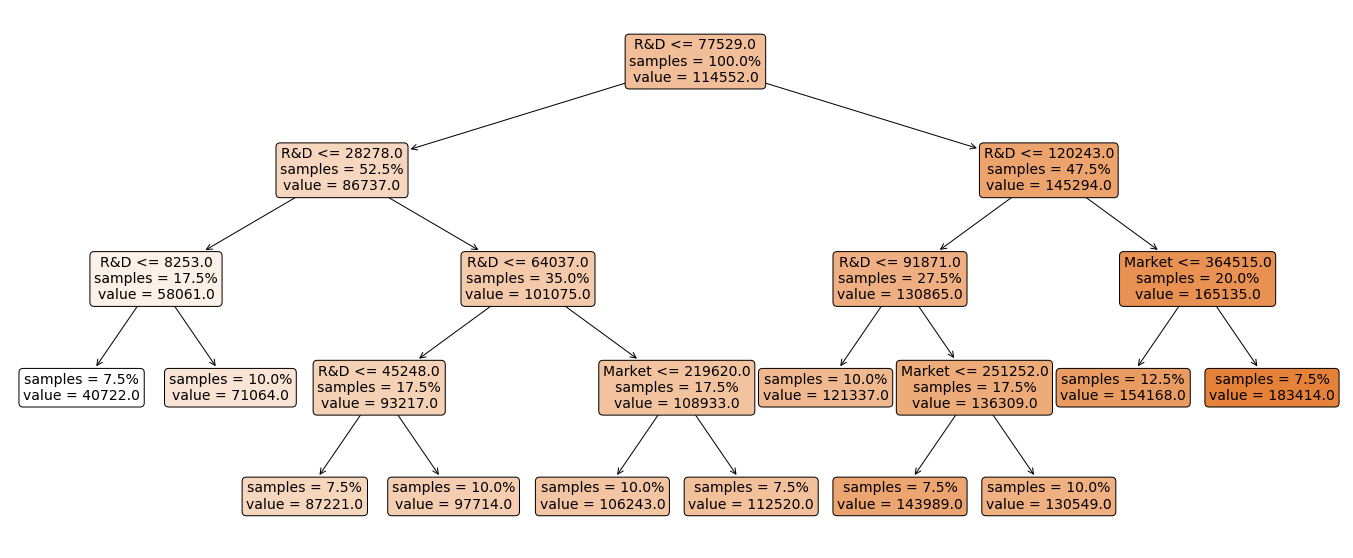

In [64]:
from sklearn.tree import plot_tree

plt.figure(figsize=(24,10))
plot_tree(model, 
          fontsize=14, 
          feature_names=["R&D","Admin", "Market", "CA", "FL", "NY"], 
          rounded=True, 
          precision=0, 
          proportion=True, 
          filled=True,
          impurity=False)
plt.show()

With this, we can show to our Venture Capitalist how to determine the success of a startup by predicting their expected profit. For this, we only need to know the R&D Spend and the Market Spend. Our model is capable of explaining 98% of the variability of the data from the test set.